In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xarray as xr

# set plotly as default pandas plot

pd.options.plotting.backend = "plotly"

In [2]:
station = "Papa"

In [3]:
data = xr.load_dataset(f"../data/1_products/{station}_obs.zarr", engine="zarr")
data

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 623, latitude: 12, longitude: 26, layer: 1)
Coordinates:
  * latitude   (latitude) float64 96B 46.5 47.5 48.5 49.5 ... 55.5 56.5 57.5
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 208B -156.5 -153.5 -152.5 ... -129.5 -128.5
  * time       (time) datetime64[ns] 5kB 1995-09-24 1995-09-25 ... 2020-08-31
Data variables:
    day        (time, latitude, longitude, layer) float64 2MB nan nan ... nan
    night      (time, latitude, longitude, layer) float64 2MB nan nan ... nan

# Remove outliers


In [4]:
q1 = data.quantile(0.25, dim=["time", "latitude", "longitude"])
q3 = data.quantile(0.75, dim=["time", "latitude", "longitude"])
iqr = q3 - q1

In [5]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [6]:
new_data = data.where((data > lower_bound) & (data < upper_bound))

In [7]:
print("Original data")
print(f"Number of observation = {int(data.day.notnull().sum() + data.night.notnull().sum())}")
print(f"Number of observation in same place during same day = {int((data.day.notnull() & data.night.notnull()).sum())}")

print("\nWithout outliers")
print(f"Number of observation = {int(new_data.day.notnull().sum() + new_data.night.notnull().sum())}")
print(
    f"Number of observation in same place during same day = {int((new_data.day.notnull() & new_data.night.notnull()).sum())}"
)

Original data
Number of observation = 757
Number of observation in same place during same day = 37

Without outliers
Number of observation = 709
Number of observation in same place during same day = 31


Text(0.5, 1.0, 'Number of days with day-night difference > 0')

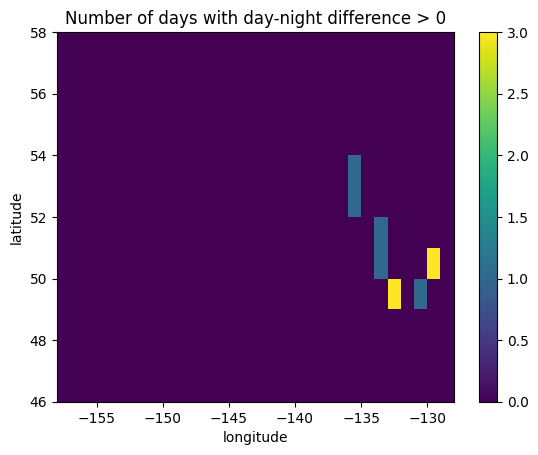

In [8]:
((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0).sum(
    "time"
).plot()
plt.title("Number of days with day-night difference > 0")

In [9]:
removed = (
    ((xr.where(new_data.day.notnull() & new_data.night.notnull(), new_data.day - new_data.night, np.nan)) > 0)
    .sum(["latitude", "longitude"])
    .resample({"time": "1YE"})
    .sum()
    .rename("value")
    .to_dataframe()
    .reset_index()
    .query("value > 0")
)

removed.plot(kind="scatter", x="time", y="value", title=f"Removed values : {removed.value.sum() * 2}")

# Remove observations when day > night


In [10]:
# condition_day_greater_night = (new_data["day"] > new_data["night"]) & (
#     new_data["day"].notnull() & new_data["night"].notnull()
# )
# final_data = xr.where(condition_day_greater_night, np.nan, new_data)
# final_data

## DAY


In [11]:
pd.DataFrame(
    {
        "original": data.day.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
        "post-processed": new_data.day.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
    }
).plot(title="Day observations", kind="scatter", opacity=0.5).update_traces(mode="lines+markers")

In [12]:
data_to_plot = pd.DataFrame(
    {
        "original": data.day.mean(["time"]).dropna("latitude", how="all").dropna("longitude", how="all").to_series(),
        "post-processed": new_data.day.mean(["time"])
        .dropna("latitude", how="all")
        .dropna("longitude", how="all")
        .to_series(),
    }
)

figure = px.scatter_3d(data_to_plot.reset_index(), x="longitude", y="latitude", z="original", title="Day observations")

figure.add_scatter3d(
    x=data_to_plot.reset_index().longitude,
    y=data_to_plot.reset_index().latitude,
    z=data_to_plot["post-processed"],
    mode="markers",
    name="post-processed",
)

figure.update_traces(marker={"size": 0}).update_layout(
    scene={
        "xaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "yaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "aspectmode": "manual",
        "aspectratio": {"x": 2, "y": 1, "z": 0.5},
        "camera": {"eye": {"x": 0.80, "y": 0.80, "z": 0.80}},
    },
    title=f"Grid of Longitude and Latitude : {station}",
    height=500,
)

## NIGHT


In [13]:
pd.DataFrame(
    {
        "original": data.night.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
        "post-processed": new_data.night.mean(["latitude", "longitude", "layer"]).dropna("time").to_series(),
    }
).plot(title="Day observations", kind="scatter", opacity=0.5).update_traces(mode="lines+markers")

In [14]:
data_to_plot = pd.DataFrame(
    {
        "original": data.night.mean(["time"]).dropna("latitude", how="all").dropna("longitude", how="all").to_series(),
        "post-processed": new_data.night.mean(["time"])
        .dropna("latitude", how="all")
        .dropna("longitude", how="all")
        .to_series(),
    }
)

figure = px.scatter_3d(data_to_plot.reset_index(), x="longitude", y="latitude", z="original", title="Day observations")

figure.add_scatter3d(
    x=data_to_plot.reset_index().longitude,
    y=data_to_plot.reset_index().latitude,
    z=data_to_plot["post-processed"],
    mode="markers",
    name="post-processed",
)

figure.update_traces(marker={"size": 0}).update_layout(
    scene={
        "xaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "yaxis": {"backgroundcolor": "rgba(0,0,0,0)"},
        "aspectmode": "manual",
        "aspectratio": {"x": 2, "y": 1, "z": 0.5},
        "camera": {"eye": {"x": 0.80, "y": 0.80, "z": 0.80}},
    },
    title=f"Grid of Longitude and Latitude : {station}",
    height=500,
)

# Export


In [15]:
new_data.to_zarr(f"../data/1_products/{station}_obs_filtered.zarr", mode="w")